In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix

# no past_proficient_score

In [2]:
scantronReading_38_encoded_df = pd.read_csv('../dataframes/scantronReading_38_encoded.csv')
scantronReading_38_encoded_df.head()

,studentId,level,dataSource,is_proficient,proficient_score,school_Elementary A,school_Elementary School B,school_Elementary School E,school_Elementary School F,school_Intermediate School E,...,past_proficient_score,subject_math,subject_reading,subject_science,subject_social-studies,subject_music,subject_art,subject_performing-arts,subject_phys-ed,subject_career-prep
0,44777,7,value_scantronReading,False,0.993342,False,False,False,False,False,...,0.969279,2,2,2,2,1,0,0,0,0
1,44783,7,value_scantronReading,False,0.997179,False,False,False,False,False,...,1.009665,2,2,2,1,0,0,0,0,0
2,44784,6,value_scantronReading,False,0.947277,False,False,False,False,False,...,0.934354,2,2,2,2,1,0,0,0,0
3,44807,7,value_scantronReading,True,1.014669,False,False,False,False,False,...,1.028650,2,2,1,2,0,0,0,0,0
4,44809,7,value_scantronReading,False,0.934665,False,False,False,False,False,...,0.949085,2,2,2,2,1,0,0,0,0


In [4]:
X = scantronReading_38_encoded_df.drop(['studentId', 'dataSource', 'is_proficient', 'proficient_score', 'level', 'past_proficient_score'], axis=1)
y = scantronReading_38_encoded_df['proficient_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=scantronReading_38_encoded_df['is_proficient'])

In [5]:
rf_best_params = {'max_depth': 5, 'n_estimators': 100}

In [12]:
max_depth = [5,15, 30]
n_estimators = [100,250,400]
param_grid = {'max_depth' : list(max_depth), 'n_estimators' : list(n_estimators)}

In [13]:
# Grid Search to find the best hyperparameters 

print("Running Grid Search")
rf_regressor = RandomForestRegressor()

# will have a 3-fold cross validation 
rf_grid = GridSearchCV(rf_regressor, param_grid, cv=3, scoring='neg_root_mean_squared_error')
rf_grid_search = rf_grid.fit(X_train, y_train)

print("Done")
rf_best_params = rf_grid_search.best_params_

rf_best_params

Running Grid Search
Done


{'max_depth': 5, 'n_estimators': 400}

In [14]:
print('Begin Random Forest ')
rf_model = RandomForestRegressor(max_depth=5, n_estimators=400)
rf_model.fit(X_train,y_train)
print('End')

Begin Random Forest 
End


In [17]:
y_pred_continuous = rf_model.predict(X_test)
rsme = mean_squared_error(y_test, y_pred_continuous, squared=False)
r2 = r2_score(y_test, y_pred_continuous)


threshold = 1.1  # ADJUST
y_pred_bool = y_pred_continuous >= threshold
y_test_bool = y_test >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_bool, y_pred_bool))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_bool, y_pred_bool))


print('[RF] Root Mean Squared Error: {0}'.format(rsme))
print('[RF] R2: {0}'.format(r2))        

threshold= 1.1

Classification Report:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98      3912
        True       0.00      0.00      0.00       180

    accuracy                           0.96      4092
   macro avg       0.48      0.50      0.49      4092
weighted avg       0.91      0.96      0.93      4092


Confusion Matrix:
[[3912    0]
 [ 180    0]]
[RF] Root Mean Squared Error: 0.11387218250200301
[RF] R2: 0.00304545780778398


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

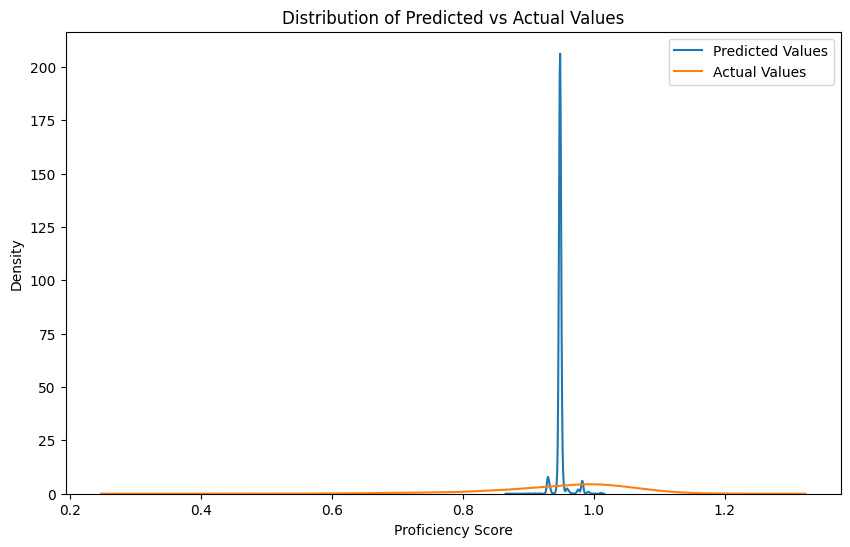

In [22]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=y_pred_continuous, label='Predicted Values')
sns.kdeplot(data=y_test, label='Actual Values')
plt.title('Distribution of Predicted vs Actual Values')
plt.xlabel('Proficiency Score')
plt.ylabel('Density')
plt.legend()
plt.show()

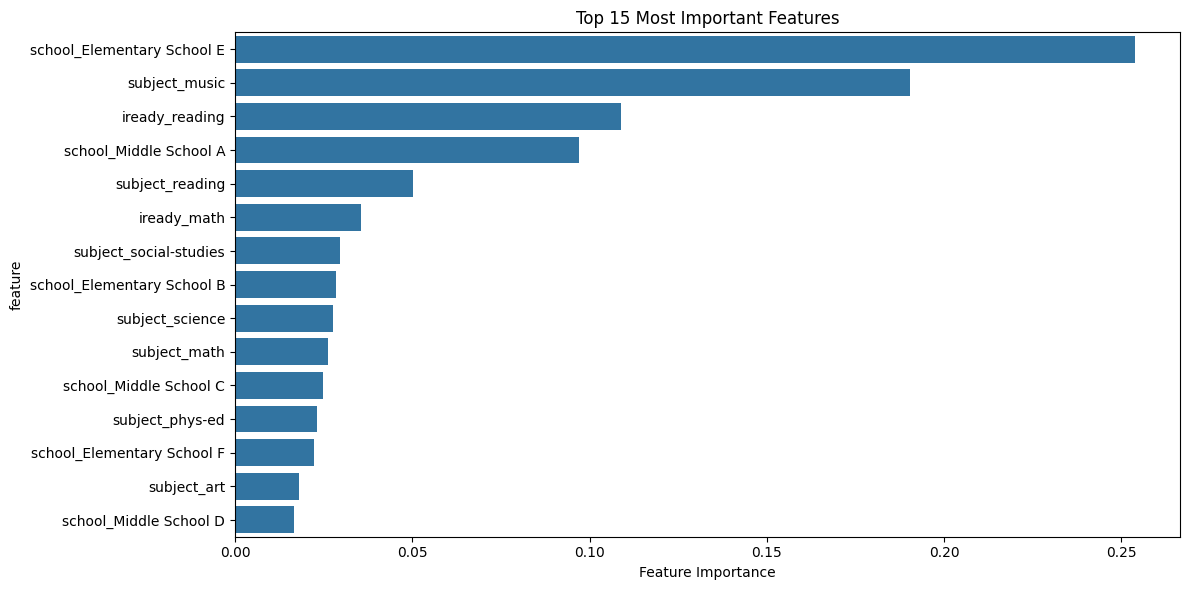


Feature Importance Scores:
                         feature  importance
2     school_Elementary School E    0.253863
15                 subject_music    0.190489
10                iready_reading    0.108866
5         school_Middle School A    0.096903
12               subject_reading    0.050145
9                    iready_math    0.035577
14        subject_social-studies    0.029626
1     school_Elementary School B    0.028411
13               subject_science    0.027628
11                  subject_math    0.026106
6         school_Middle School C    0.024771
18               subject_phys-ed    0.023120
3     school_Elementary School F    0.022265
16                   subject_art    0.018028
7         school_Middle School D    0.016536
19           subject_career-prep    0.015407
0            school_Elementary A    0.014918
8         school_Middle School F    0.013157
4   school_Intermediate School E    0.004183
17       subject_performing-arts    0.000000


In [10]:
# Get feature importance scores
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})

# Sort features by importance in descending order
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Print feature importance scores
print("\nFeature Importance Scores:")
print(feature_importance)


# w/ past_proficient_score

In [4]:
scantronReading_38_encoded_df = pd.read_csv('../dataframes/scantronReading_38_encoded.csv')
scantronReading_38_encoded_df.head()

,studentId,level,dataSource,is_proficient,proficient_score,school_Elementary A,school_Elementary School B,school_Elementary School E,school_Elementary School F,school_Intermediate School E,...,past_proficient_score,subject_math,subject_reading,subject_science,subject_social-studies,subject_music,subject_art,subject_performing-arts,subject_phys-ed,subject_career-prep
0,44777,7,value_scantronReading,False,0.993342,False,False,False,False,False,...,0.969279,2,2,2,2,1,0,0,0,0
1,44783,7,value_scantronReading,False,0.997179,False,False,False,False,False,...,1.009665,2,2,2,1,0,0,0,0,0
2,44784,6,value_scantronReading,False,0.947277,False,False,False,False,False,...,0.934354,2,2,2,2,1,0,0,0,0
3,44807,7,value_scantronReading,True,1.014669,False,False,False,False,False,...,1.028650,2,2,1,2,0,0,0,0,0
4,44809,7,value_scantronReading,False,0.934665,False,False,False,False,False,...,0.949085,2,2,2,2,1,0,0,0,0


In [6]:
X = scantronReading_38_encoded_df.drop(['studentId', 'dataSource', 'is_proficient', 'proficient_score', 'level'], axis=1)
y = scantronReading_38_encoded_df['proficient_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=scantronReading_38_encoded_df['is_proficient'])

Baseline for using past proficiency

In [12]:
X = scantronReading_38_encoded_df
y = scantronReading_38_encoded_df[['proficient_score', 'past_proficient_score']]

# Perform train-test split, retaining is_proficient in the test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, 
    random_state=123, 
    stratify=scantronReading_38_encoded_df['is_proficient']
)

print("Not proficient to proficient")
print(sum((y_test['past_proficient_score'] < 1) & (y_test['proficient_score'] > 1)))

print("Proficient to not proficient")
print(sum((y_test['past_proficient_score'] >= 1) & (y_test['proficient_score'] < 1)))

print("Size of test set")
print(y_test.shape)

X = scantronReading_38_encoded_df.drop(['studentId', 'dataSource', 'is_proficient', 'proficient_score', 'level'], axis=1)
y = scantronReading_38_encoded_df['proficient_score']


Not proficient to proficient
306
Proficient to not proficient
131
Size of test set
(4092, 2)


In [5]:
# Count rows where student was not proficient but had past proficient score > 1
print("Not proficient to proficient")
print(len(X_test[(scantronReading_38_encoded_df['is_proficient'] == False) & 
                                 (y_test['proficient_score'] > 1)]))

# Count rows where student ends up proficient but had past proficient score < 1
print("Proficient to not proficient")
print(len(scantronReading_38_encoded_df[(scantronReading_38_encoded_df['is_proficient'] == True) & 
                                 (scantronReading_38_encoded_df['past_proficient_score'] < 1)]))


Not proficient to proficient
619
Proficient to not proficient
1433


In [8]:
1 - ((619 + 1433)/20460)

0.8997067448680351

In [26]:
max_depth = [5,15, 30]
n_estimators = [100,250,400]
param_grid = {'max_depth' : list(max_depth), 'n_estimators' : list(n_estimators)}

In [27]:
# Grid Search to find the best hyperparameters 

print("Running Grid Search")
rf_regressor = RandomForestRegressor()

# will have a 3-fold cross validation 
rf_grid = GridSearchCV(rf_regressor, param_grid, cv=3, scoring='neg_root_mean_squared_error')
rf_grid_search = rf_grid.fit(X_train, y_train)

print("Done")
rf_best_params = rf_grid_search.best_params_

rf_best_params

Running Grid Search
Done


{'max_depth': 5, 'n_estimators': 400}

In [28]:
print('Begin Random Forest ')
rf_model = RandomForestRegressor(max_depth=18, n_estimators=350)
rf_model.fit(X_train,y_train)
print('End')

Begin Random Forest 
End


In [29]:
y_pred_continuous = rf_model.predict(X_test)
rsme = mean_squared_error(y_test, y_pred_continuous, squared=False)
r2 = r2_score(y_test, y_pred_continuous)


threshold = 1.1  # ADJUST
y_pred_bool = y_pred_continuous >= threshold
y_test_bool = y_test >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_bool, y_pred_bool))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_bool, y_pred_bool))


print('[RF] Root Mean Squared Error: {0}'.format(rsme))
print('[RF] R2: {0}'.format(r2))        

threshold= 1.1

Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98      3912
        True       0.66      0.31      0.42       180

    accuracy                           0.96      4092
   macro avg       0.82      0.65      0.70      4092
weighted avg       0.96      0.96      0.96      4092


Confusion Matrix:
[[3884   28]
 [ 125   55]]
[RF] Root Mean Squared Error: 0.08859303721510346
[RF] R2: 0.3965528384175575


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


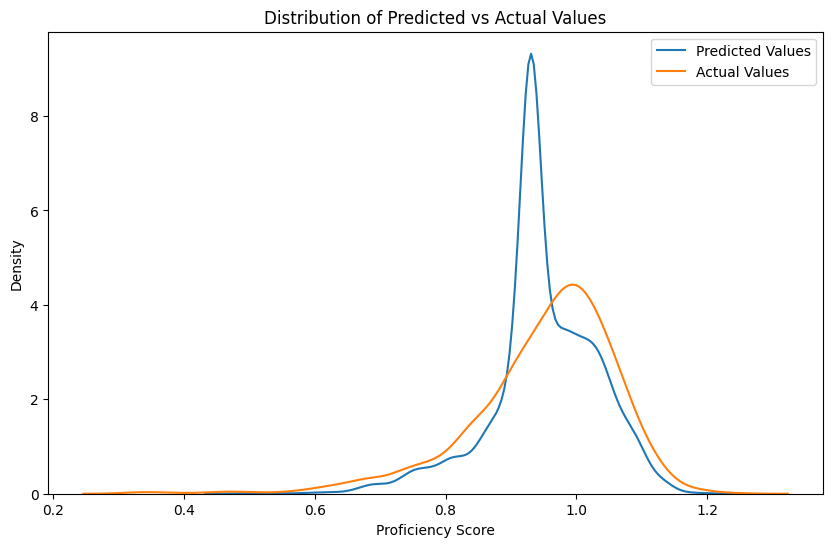

In [30]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=y_pred_continuous, label='Predicted Values')
sns.kdeplot(data=y_test, label='Actual Values')
plt.title('Distribution of Predicted vs Actual Values')
plt.xlabel('Proficiency Score')
plt.ylabel('Density')
plt.legend()
plt.show()

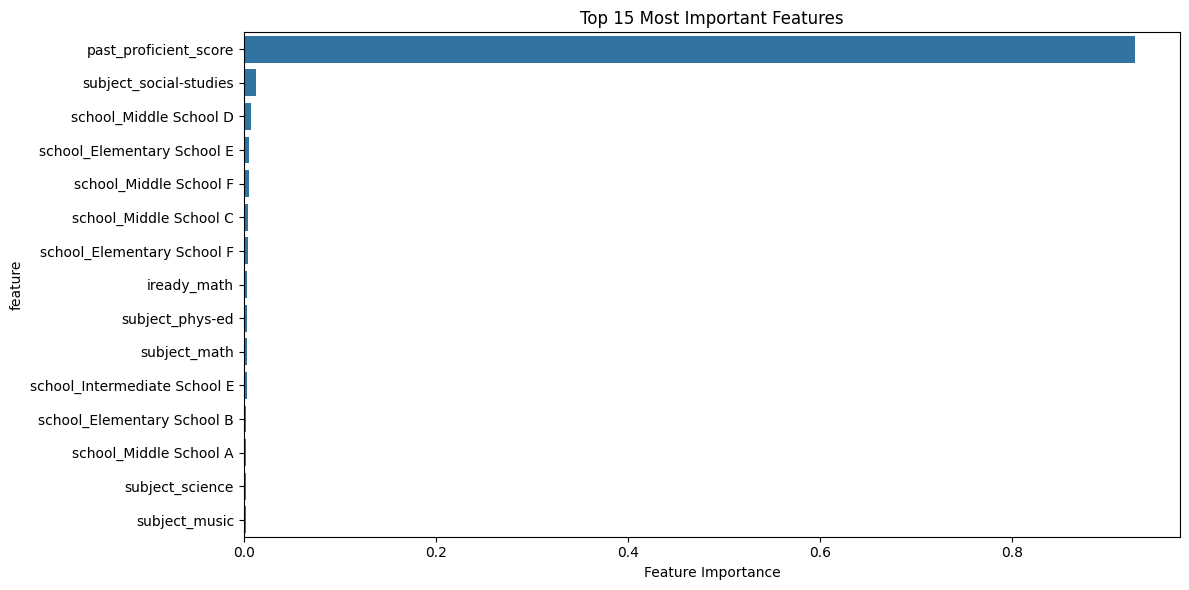


Feature Importance Scores:
                         feature  importance
11         past_proficient_score    0.928396
15        subject_social-studies    0.012420
7         school_Middle School D    0.007471
2     school_Elementary School E    0.005531
8         school_Middle School F    0.005462
6         school_Middle School C    0.004556
3     school_Elementary School F    0.004198
9                    iready_math    0.003848
19               subject_phys-ed    0.003702
12                  subject_math    0.003477
4   school_Intermediate School E    0.003278
1     school_Elementary School B    0.002559
5         school_Middle School A    0.002545
14               subject_science    0.002366
16                 subject_music    0.002343
13               subject_reading    0.001995
17                   subject_art    0.001831
10                iready_reading    0.001807
0            school_Elementary A    0.001791
20           subject_career-prep    0.000382
18       subject_performing

In [18]:
# Get feature importance scores
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})

# Sort features by importance in descending order
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Print feature importance scores
print("\nFeature Importance Scores:")
print(feature_importance)
